In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.integrate import odeint
from scipy.optimize import root
from sympy import Symbol
from sympy.solvers import solve
from manim import *

In [2]:
AXIS_LIMIT = 4

## Phase Plane of a Simple Dynamical System

Let's define the simple dynamical system as the following:

$$\frac{dx_0}{dt} = f_0(x_0, x_1)$$

$$\frac{dx_1}{dt} = f_1(x_0, x_1)$$

This is a dynamical system in two variables, $x_0$ and $x_1$. The change in the first variable is described by the function $f_0$ which is dependent on both variables, although this dependence on both variables isn't a necessity. The same is true for the change in the second variable.

Being more concrete, the functions $f_0$ and $f_1$ take the following form:

$$f_0 = -x_0 -2x_1$$

$$f_1 = 4x_0 -x_1$$

This means that $x_0$ changes with an inverse relationship to $x_0$ and $x_0$, and the dependence on $x_1$ is stronger. $x_1$ changes proportionally to $x_0$ and inverse proportionally to $x_1$, and the dependence on $x_0$ is stronger.


Now, we can define a function `dynamic_state_space` that takes concrete $x$ values and tells us the dynamics at those specific values.

In [3]:
def dynamic_state_space(x, t, dynamics):
   assert(len(x) == len(dynamics))
   dx_dt = np.zeros(len(x))
   for i in range(len(x)):
     dx_dt[i] = dynamics[i](*x)
   return dx_dt

f_0 = lambda x_0, x_1: -x_0 -2*x_1
f_1 = lambda x_0, x_1: 4*x_0 -x_1

dynamics = [f_0, f_1]

### Getting Instantaneous Values
We can try testing this function for different values of $x$, such as $x$ at the origin, $x$ somewhere along one axis, $x$ somewhere along the other axis, and $x$ in a more realistic place.

In [4]:
x = [0, 0]
print(f"x: {x}, dx/dt: {dynamic_state_space(x, 0, dynamics)}")
x = [2, 0]
print(f"x: {x}, dx/dt: {dynamic_state_space(x, 0, dynamics)}")
x = [0, 2]
print(f"x: {x}, dx/dt: {dynamic_state_space(x, 0, dynamics)}")
x = [1, 1]
print(f"x: {x}, dx/dt: {dynamic_state_space(x, 0, dynamics)}")

x: [0, 0], dx/dt: [0. 0.]
x: [2, 0], dx/dt: [-2.  8.]
x: [0, 2], dx/dt: [-4. -2.]
x: [1, 1], dx/dt: [-3.  3.]


### Plotting the Phase Plane

Now instead of evaluating the dynamics over a few random points, we can define a grid over which to evaluate the dynamics, and then plot the results to get a more comprehensive picture of what the system dynamics look like.

In [5]:
def get_phase_plane(dynamics, x_0_range=(-AXIS_LIMIT, AXIS_LIMIT), x_1_range=(-AXIS_LIMIT, AXIS_LIMIT), num_points=20):
    x_0 = np.linspace(*x_0_range, num_points)
    x_1 = np.linspace(*x_1_range, num_points)

    X0, X1 = np.meshgrid(x_0, x_1)
    # projections of the trajectory tangent vector 
    dx_0 = np.zeros(X0.shape)
    dx_1 = np.zeros(X1.shape)

    shape1, shape2 = X1.shape

    for index_shape1 in range(shape1):
        for index_shape2 in range(shape2):
            dxdt_at_x=dynamic_state_space([X0[index_shape1,index_shape2],X1[index_shape1,index_shape2]], 0, dynamics)
            dx_0[index_shape1,index_shape2]=dxdt_at_x[0]
            dx_1[index_shape1,index_shape2]=dxdt_at_x[1]   
    return X0, X1, dx_0, dx_1  

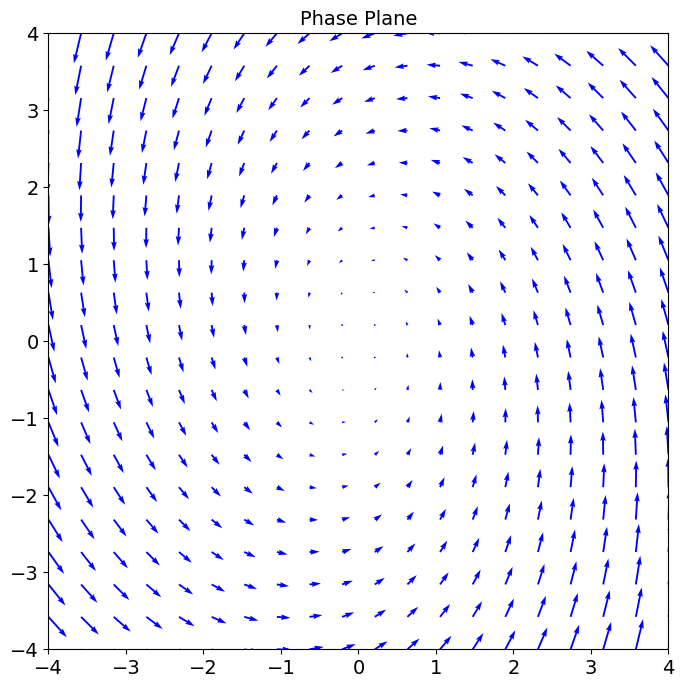

In [6]:
def plot_phase_plane(dynamics):
    X0, X1, dx_0, dx_1 = get_phase_plane(dynamics)
    plt.figure(figsize=(8, 8))
    plt.quiver(X0, X1, dx_0, dx_1, color='b')
    plt.xlim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.ylim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.title('Phase Plane', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

plot_phase_plane(dynamics)

### Plotting the trajectory from an initial state

We can also plot the trajectory that the system takes given an initial state and overlay that on the phase plane. scipy has a function called `odeint` which takes a set of functions and an initial state and generates its trajectory through integration.

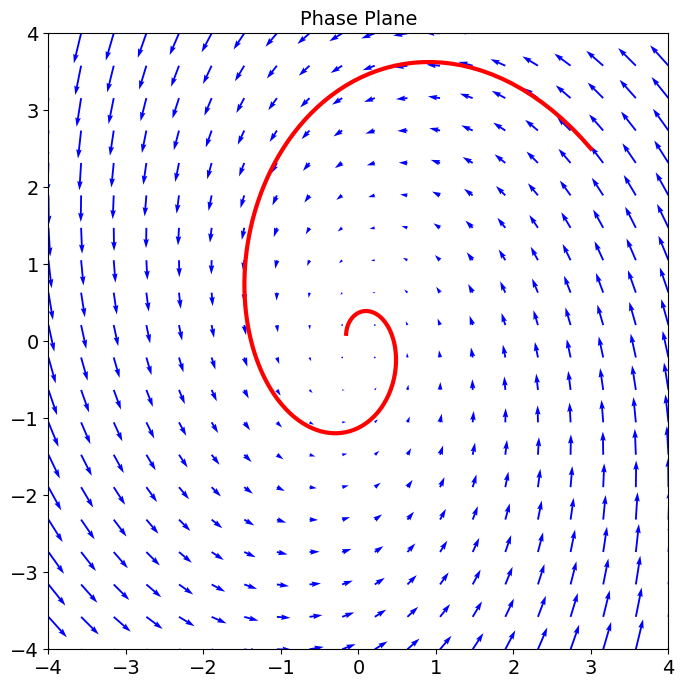

In [7]:
initial_state=np.array([3,2.5])
simulation_time=np.linspace(0,3,200)

def plot_phase_plane_with_state_trajectory(dynamics, initial_state, simulation_time):
    solution_state=odeint(dynamic_state_space,initial_state,simulation_time, args=(dynamics,))
    X0, X1, dx_0, dx_1 = get_phase_plane(dynamics)
    #adjust the figure size
    plt.figure(figsize=(8, 8))
    # plot the phase portrait
    plt.quiver(X0,X1,dx_0,dx_1,color='b')
    # adjust the axis limits
    plt.xlim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.ylim(-AXIS_LIMIT, AXIS_LIMIT)
    # add the state trajectory plot
    plt.plot(solution_state[:,0], solution_state[:,1], color='r',linewidth=3)
    # insert the title
    plt.title('Phase Plane', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()
plot_phase_plane_with_state_trajectory(dynamics, initial_state, simulation_time)

### Adding fixed points and nullclines

We can already see based on the behavior of the system above that there is a fixed point in the middle of the diagram. We should plot it as well as the nullclines, which are where the system doesn't change with respect to one variable. The system is simple enough that simply setting the derivatives to 0 and moving one variable to the other side would give us the nullclines:

$$ x_0 = -2x_1$$
$$ 4x_0 = x_1$$

This rearrangement of the variables shows that $\frac{dx_0}{dt}$ is 0 when $x_0$ is equal to -2 times $x_1$. Likewise, $\frac{dx_1}{dt}$ is 0 when $x_1$ is 4 times $x_0$.

In Python we'll use scipy's `root` function to do the algebra that would solve the equations. 

<Figure size 640x480 with 0 Axes>

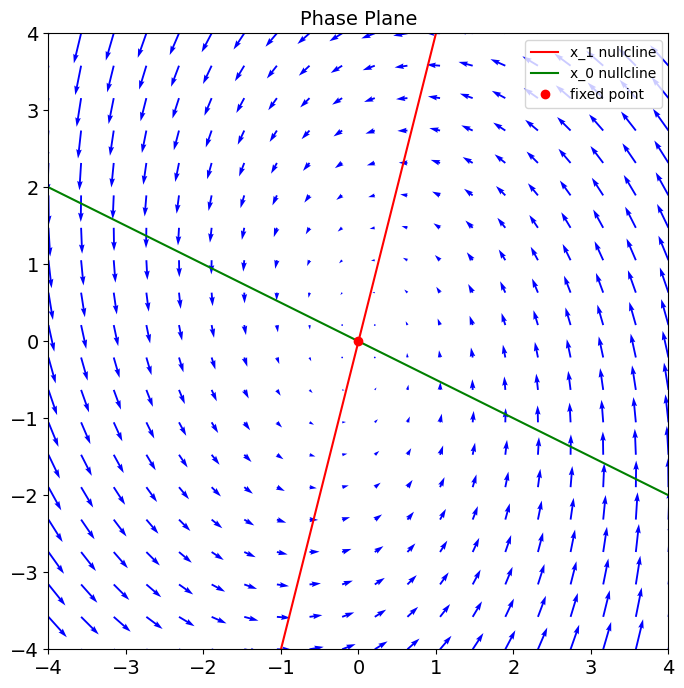

In [8]:
def system(vars, dynamics):
    assert len(vars) == len(dynamics)
    result = []
    for i in range(len(vars)):
        result.append(dynamics[i](*vars))
    return result

def is_very_close(a, b, tol=1e-2):
    """ check if two coordinates are very close, the coordinates are tuples"""
    for i in range(len(a)):
        if abs(a[i] - b[i]) > tol:
            return False
    return True

# due to floating point precision, we need to verify the fixed point by checking if the derivatives are close to 0
def verify_fixed_point(dynamics, fixed_point):
    result = [dynamics[i](*fixed_point) for i in range(len(dynamics))]
    return is_very_close(result, [0]*len(dynamics))

def find_fixed_points(dynamics):
    num_vars = len(dynamics)
    x_ranges = []
    for i in range(num_vars):
        x_ranges.append(np.linspace(-AXIS_LIMIT, AXIS_LIMIT, 10))
    # take cross product of all x ranges to get initial guesses
    initial_guesses = np.array(np.meshgrid(*x_ranges)).T.reshape(-1, num_vars)
    fixed_points = []
    for initial_guess in initial_guesses:
        solution = root(system, initial_guess, args=(dynamics,))
        solution_tuple = tuple(solution.x)
        if not any([is_very_close(solution_tuple, fixed_point) for fixed_point in fixed_points]) and verify_fixed_point(dynamics, solution_tuple):
            fixed_points.append(solution_tuple)
    return fixed_points

def find_nullclines_and_fixed_points(dynamics):
    num_vars = len(dynamics)
    x = [Symbol(f'x_{i}') for i in range(num_vars)]
    nullclines = []
    for i in range(num_vars):
        nullclines.append(solve(dynamics[i](*x), x[i]))
    fixed_points = find_fixed_points(dynamics)
    return nullclines, fixed_points

def plot_phase_plane_with_nullclines_and_fixed_points(dynamics):
    plt.clf()
    X0, X1, dx_0, dx_1 = get_phase_plane(dynamics)
    nullclines, fixed_points = find_nullclines_and_fixed_points(dynamics)
    num_vars = len(dynamics)
    x = [Symbol(f'x_{i}') for i in range(num_vars)]
    
    x_0_values = np.linspace(-AXIS_LIMIT, AXIS_LIMIT, 100)
    x_1_values = np.linspace(-AXIS_LIMIT, AXIS_LIMIT, 100)
    x_0_nullcline_values = [nullclines[0][0].subs(x[1], x_1_value) for x_1_value in x_1_values]
    x_1_nullcline_values = [nullclines[1][0].subs(x[0], x_0_value) for x_0_value in x_0_values]
    plt.figure(figsize=(8, 8))
    plt.quiver(X0,X1,dx_0,dx_1,color='b')
    plt.xlim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.ylim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.title('Phase Plane', fontsize=14)
    plt.plot(x_0_values, x_1_nullcline_values, 'r', label='x_1 nullcline')
    plt.plot(x_0_nullcline_values, x_1_values, 'g', label='x_0 nullcline')
    if type(fixed_points) == dict:
        plt.plot(fixed_points[x[0]], fixed_points[x[1]], 'ro', label='fixed point')
    else: # multiple fixed points
        for fixed_point in fixed_points:
            plt.plot(fixed_point[0], fixed_point[1], 'ro', label='fixed point')
    plt.legend()
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

plot_phase_plane_with_nullclines_and_fixed_points(dynamics)

## Phase Plane of a Nonlinear Dynamical System

Making things slightly more complicated, we can now define the dynamics of the system with a nonlinear component in the change of the second variable:

$$ f_0 = x_0+x_1 $$
$$ f_1 = -x_0^2 -x_0 + x_1 $$

Plotting the phase plane, we see more curvature in the vector field and we also see a non-linear nullcline corresponding to the dynamics of the second variable. Because it intersects at two points with the other nullcline, there are now two fixed points instead of one. We can see that near those fixed points the magnitude of the vectors are very small.

<Figure size 640x480 with 0 Axes>

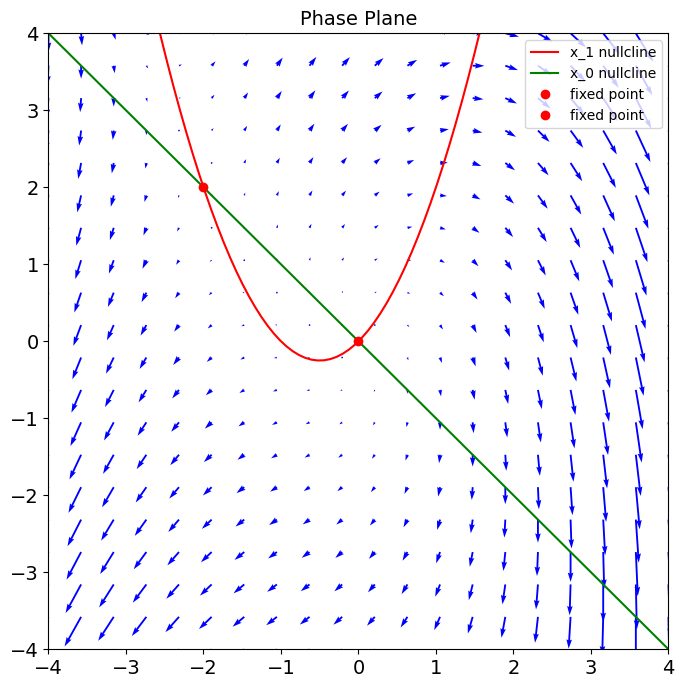

In [9]:
nonlinear_dynamics = [lambda x_0, x_1: x_0 + x_1, lambda x_0, x_1: -x_0**2 - x_0 + x_1]
plot_phase_plane_with_nullclines_and_fixed_points(nonlinear_dynamics)

### Parameterizing the System and Bifurcating

We can modify the dynamics of the first variable by adding a parameter to it, which would effectively shift its nullcline. Doing so opens up the possibility of the system bifurcating with the adjustment of that parameter. 

$$ f_0 = x_0+x_1 + c$$
$$ f_1 = -x_0^2 -x_0 + x_1 $$

You can change the parameter $c$ by adjusting the slider and seeing how the phase plane changes. At a certain value for c, the number of fixed points reduces to 1 and then to 0.

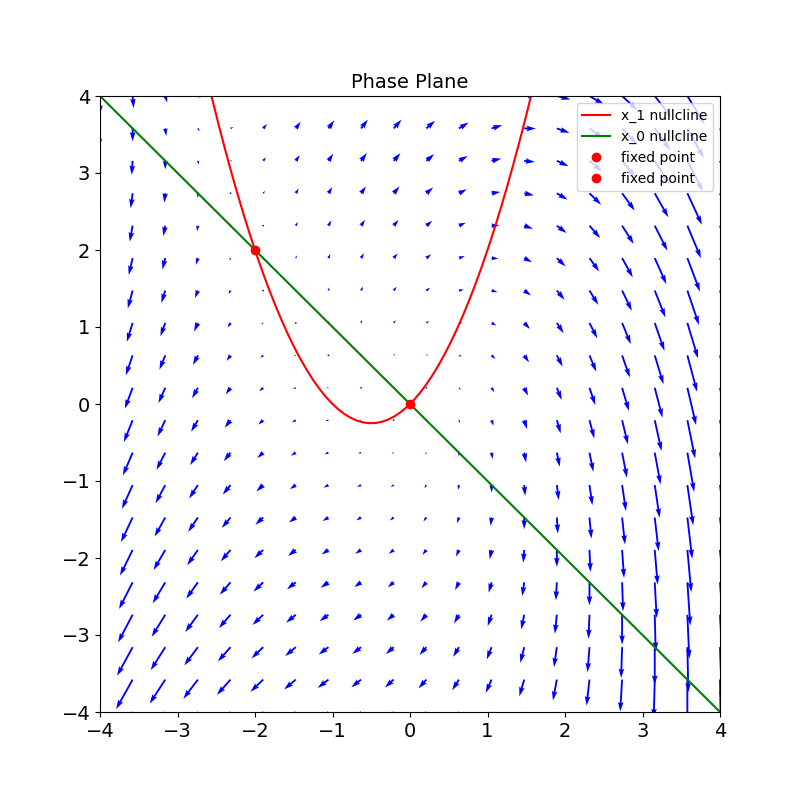

IntSlider(value=0, continuous_update=False, description='parameter c', max=5, min=-5)

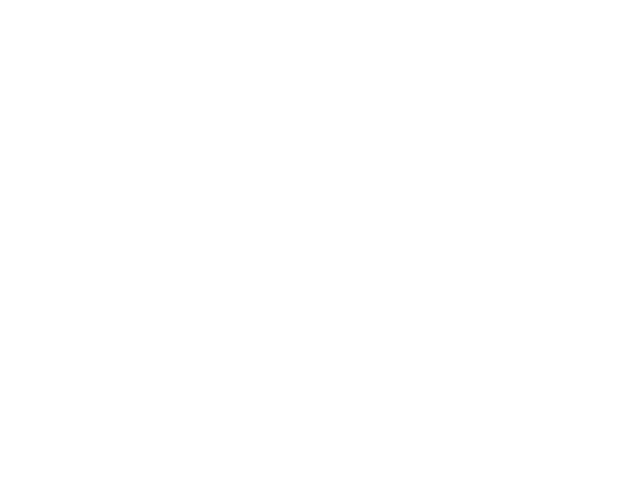

In [10]:
%matplotlib ipympl
import ipywidgets as widgets
c = 0
nonlinear_dynamics = [lambda x_0, x_1: x_0 + x_1 + c, lambda x_0, x_1: -x_0**2 - x_0 + x_1]
plot_phase_plane_with_nullclines_and_fixed_points(nonlinear_dynamics)

def update(change):
    c = change.new
    plt.clf()
    dynamics = [lambda x_0, x_1: x_0 + x_1 + c, lambda x_0, x_1: -x_0**2 - x_0 + x_1]
    X0, X1, dx_0, dx_1 = get_phase_plane(dynamics)
    nullclines, fixed_points = find_nullclines_and_fixed_points(dynamics)
    num_vars = len(dynamics)
    x = [Symbol(f'x_{i}') for i in range(num_vars)]
    
    x_0_values = np.linspace(-AXIS_LIMIT, AXIS_LIMIT, 100)
    x_1_values = np.linspace(-AXIS_LIMIT, AXIS_LIMIT, 100)
    x_0_nullcline_values = [nullclines[0][0].subs(x[1], x_1_value) for x_1_value in x_1_values]
    x_1_nullcline_values = [nullclines[1][0].subs(x[0], x_0_value) for x_0_value in x_0_values]
    plt.quiver(X0,X1,dx_0,dx_1,color='b')
    plt.xlim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.ylim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.plot(x_0_values, x_1_nullcline_values, 'r', label='x_1 nullcline')
    plt.plot(x_0_nullcline_values, x_1_values, 'g', label='x_0 nullcline')
    if type(fixed_points) == dict:
        plt.plot(fixed_points[x[0]], fixed_points[x[1]], 'ro', label='fixed point')
    else: # multiple fixed points
        for fixed_point in fixed_points:
            plt.plot(fixed_point[0], fixed_point[1], 'ro', label='fixed point')
    plt.legend()
    plt.tick_params(axis='both', which='major', labelsize=14)

int_slider = widgets.IntSlider(
    value=0, 
    min=-5, max=5, step=1,
    description='parameter c',
    continuous_update=False
)
int_slider.observe(update, 'value')
int_slider


### Animating the bifurcation

Here I'm using the Manim library to generate the phase plane and vector field representing the system. The system has an initial value of the constant $c$ as $-2$, and over time the plot animates to show how the system changes as that constant grows to $5$.

In [11]:
%%manim -qm -v WARNING PhasePortrait

class PhasePortrait(Scene):
    def construct(self):
        # Create axes
        axes = Axes(
            x_range=[-5, 5, 1],
            y_range=[-5, 5, 1],
            axis_config={"color": BLUE}
        )

        labels = axes.get_axis_labels(x_label="x", y_label="y")
        A = ValueTracker(-2)

        # Define the vector field
        def vector_field_func(pos):
            x, y = pos[:2]
            return np.array([x+y, -x**2-x+y + A.get_value(), 0])

        vector_field = ArrowVectorField(
            vector_field_func,
            x_range=[-5, 5],
            y_range=[-5, 5],
            colors=[BLUE, GREEN]
        )
        vector_field.add_updater(lambda func : func.become(ArrowVectorField(
            vector_field_func,
            x_range=[-5, 5],
            y_range=[-5, 5],
            colors=[BLUE, GREEN]
        )))

        # Create stream lines (optional for better visualization)
        stream_lines = StreamLines(
            vector_field_func,
            x_range=[-5, 5],
            y_range=[-5, 5],
            stroke_width=1,
            max_anchors_per_line=30,
            virtual_time=3,
        )

        stream_lines.add_updater(lambda func : func.become(StreamLines(
            vector_field_func,
            x_range=[-5, 5],
            y_range=[-5, 5],
            stroke_width=1,
            max_anchors_per_line=30,
            virtual_time=3,
        )))

        # Add everything to the scene
        self.add(axes, labels, vector_field, stream_lines)
        self.play(A.animate.set_value(5),run_time=7)
        self.wait(5)

Manim Community v0.18.1